Plot area taus for all sampling iterations.


In [1]:
import numpy as np
import pandas as pd
import pickle
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
import seaborn as sns

from isttc.scripts.cfg_global import project_folder_path
from isttc.tau import fit_single_exp, fit_single_exp_2d, func_single_exp_monkey

In [2]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
def prep_trials_dfs(trial_dict, acf_cols_, units_info_df_subset_):
    num_units = len(trial_dict)
    random_indices = np.random.randint(0, 100, size=num_units)
    print(f'Random indices shape: {random_indices.shape}')

    unit_ids = list(trial_dict.keys())
    acf_samples = [
        trial_dict[uid]['acf'][rand_idx]
        for uid, rand_idx in zip(unit_ids, random_indices)
    ]

    trial_acf_df = pd.DataFrame(np.vstack(acf_samples), columns=acf_cols)
    trial_acf_df.insert(0, 'unit_id', unit_ids)

    # Merge with unit metadata
    merged_df = pd.merge(trial_acf_df, units_info_df, on='unit_id', how='left')
    print(f'N units in merged DataFrame: {len(merged_df)}')

    # Drop rows with missing data
    n_nans = merged_df.isna().any(axis=1).sum()
    cleaned_df = merged_df.dropna()
    print(f'N rows with NaNs: {n_nans} removed. New N: {len(cleaned_df)}')

    return cleaned_df

def calc_population_tau_2d(acf_df_, acf_cols_, start_idx_, func_to_fit_, verbose_=False):
    acf_2d = acf_df_[acf_cols_].values
    fit_popt, fit_pcov, tau, tau_ci, fit_r_squared, explained_var, log_message = fit_single_exp_2d(acf_2d, start_idx_, func_to_fit_)
    if verbose_:
        print(f'tau {tau*50}, 95% CI {tau_ci[0]*50},{tau_ci[1]*50}')
    return {'tau_ms':tau*50,
            'tau_lower_ms':tau_ci[0]*50, 
            'tau_upper_ms':tau_ci[1]*50, 
            'fit_r_squared': fit_r_squared, 
            'explained_var': explained_var, 
            'popt': fit_popt,
            'n_acfs': len(acf_df_)}

def get_method_tau_dict(areas_, acf_df_, acf_cols_, verbose_=False):
    taus_dict = {}
    for area in areas_:
        if verbose_:
            print(f'processing area {area}')
        acf_df_area = acf_df_.query('ecephys_structure_acronym == @area').copy()
        if verbose_:
            print(f'N units for brain area {area}: {len(acf_df_area)}')
        taus_dict[area] = calc_population_tau_2d(acf_df_area, acf_cols_, 2, func_single_exp_monkey)
    return taus_dict

In [38]:
generate = False
save_fig = False

In [5]:
dataset_folder = project_folder_path + 'results\\mice\\dataset\\cut_30min\\'
fig_folder = project_folder_path + 'results\\mice\\fig_draft_paper\\'

#### Load data

In [24]:
if generate:
    n_lags = 20
    acf_cols = ['acf_' + str(i) for i in range(n_lags)]
    print('acf_cols {}'.format(acf_cols))
    
    units_info_df = pd.read_pickle(dataset_folder + 'sua_list_constrained_units_df.pkl')
    units_info_df_subset = units_info_df[['unit_id', 'ecephys_structure_acronym', 'fr_hz_spont_30min']].copy()
    
    with open(dataset_folder + 'binned\\pearsonr_trial_avg_50ms_20lags_dict.pkl', "rb") as f:
        pearsonr_trial_avg_trial_dict = pickle.load(f)
    print(f'N signals pearsonr_trial_avg_trial_dict {len(pearsonr_trial_avg_trial_dict)}')
    
    with open(dataset_folder + 'non_binned\\sttc_trial_avg_50ms_20lags_dict.pkl', "rb") as f:
        sttc_trial_avg_trial_dict = pickle.load(f)
    print(f'N signals sttc_trial_avg_trial_dict {len(sttc_trial_avg_trial_dict)}')
    
    with open(dataset_folder + 'non_binned\\sttc_trial_concat_50ms_20lags_dict_25dt.pkl', "rb") as f:
        sttc_trial_concat_trial_dict = pickle.load(f)
    print(f'N signals sttc_trial_concat_trial_dict {len(sttc_trial_concat_trial_dict)}')
    
    brain_areas = units_info_df['ecephys_structure_acronym'].unique()
    print(f'brain_areas {brain_areas}')
    
    n_samples = 50
    
    area_taus_dict_random = {}
    for ii in range(n_samples):
        # using random ACF per unit 
        print(f'Processing {ii}...')
        pearsonr_trial_avg_acf_random_df = prep_trials_dfs(pearsonr_trial_avg_trial_dict,
                                                                                    acf_cols[:-1], units_info_df_subset) 
        sttc_trial_avg_acf_random_df = prep_trials_dfs(sttc_trial_avg_trial_dict,
                                                                                        acf_cols[:-1], units_info_df_subset) 
        sttc_trial_concat_acf_random_df = prep_trials_dfs(sttc_trial_concat_trial_dict,
                                                                                        acf_cols[:-1], units_info_df_subset) 
        
        acf_pearsonr_trial_avg_taus_random_dict = get_method_tau_dict(brain_areas, pearsonr_trial_avg_acf_random_df, acf_cols[:-1])
        acf_sttc_trial_avg_taus_random_dict = get_method_tau_dict(brain_areas, sttc_trial_avg_acf_random_df, acf_cols[:-1])
        acf_sttc_trial_concat_taus_random_dict = get_method_tau_dict(brain_areas, sttc_trial_concat_acf_random_df, acf_cols[:-1])
        
        area_taus_dict_random[ii] = {'pearsonr_trial_avg_random': acf_pearsonr_trial_avg_taus_random_dict, 
                      'sttc_trial_avg_random': acf_sttc_trial_avg_taus_random_dict, 
                      'sttc_trial_concat_random': acf_sttc_trial_concat_taus_random_dict}

    # save
    class NumpyEncoder(json.JSONEncoder):
        def default(self, obj):
            if isinstance(obj, np.ndarray):
                return obj.tolist()  # Convert ndarray to list
            return super().default(obj)
    
    with open(dataset_folder + 'area_taus_dict_random.json', 'w') as f:
        json.dump(area_taus_dict_random, f, cls=NumpyEncoder, indent=4)  
else:
    with open(dataset_folder + 'area_taus_dict.json', 'r') as f1:
        area_taus_dict = json.load(f1)
        
    with open(dataset_folder + 'area_taus_dict_random.json', 'r') as f2:
        area_taus_dict_50_iter = json.load(f2)  

#### Plots

In [28]:
color_acf_full = '#718190'
color_isttc_full = '#1ba9e2'
color_pearson_trail_avg =  '#f4a91c' 
color_sttc_trail_concat = '#955da2' 

colors=[color_acf_full, color_isttc_full, color_pearson_trail_avg, color_sttc_trail_concat]

brain_areas_axes_ticks = ['LGd', 'VISp', 'VISl', 'VISrl', 'LP', 'VISal', 'VISpm', 'VISam']
brain_areas_names = ['LGN', 'V1', 'LM', 'RL', 'LP', 'AL', 'PM', 'AM']

In [25]:
# make a df for plotting
rows = []

for outer_key, method_dict in area_taus_dict_random.items():
    for method, area_dict in method_dict.items():
        for area, metrics in area_dict.items():
            row = {
                'iteration': outer_key, 
                'method': method,
                'area': area
            }
            row.update(metrics)
            rows.append(row)

df_all = pd.DataFrame(rows)

In [11]:
# make a df for plotting
rows = []

for method, area_dict in area_taus_dict.items():
    for area, metrics in area_dict.items():
        row = {
            'method': method,
            'area': area
        }
        row.update(metrics)
        rows.append(row)

df_all_full = pd.DataFrame(rows)

df_all_full_subset = df_all_full[df_all_full['method'].isin(['acf_full', 'isttc_full', 'pearsonr_trial_avg_random',
                                                             'sttc_trial_concat_random'])].copy()

C:\Users\ipochino\AppData\Local\Temp\ipykernel_19308\1268612116.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df_all_full_subset.query('area == @area'), x='method', y='tau_ms', palette=colors, s=7, order=categories,
C:\Users\ipochino\AppData\Local\Temp\ipykernel_19308\1268612116.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df_all_full_subset.query('area == @area'), x='method', y='tau_ms', palette=colors, s=7, order=categories,
C:\Users\ipochino\AppData\Local\Temp\ipykernel_19308\1268612116.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for th

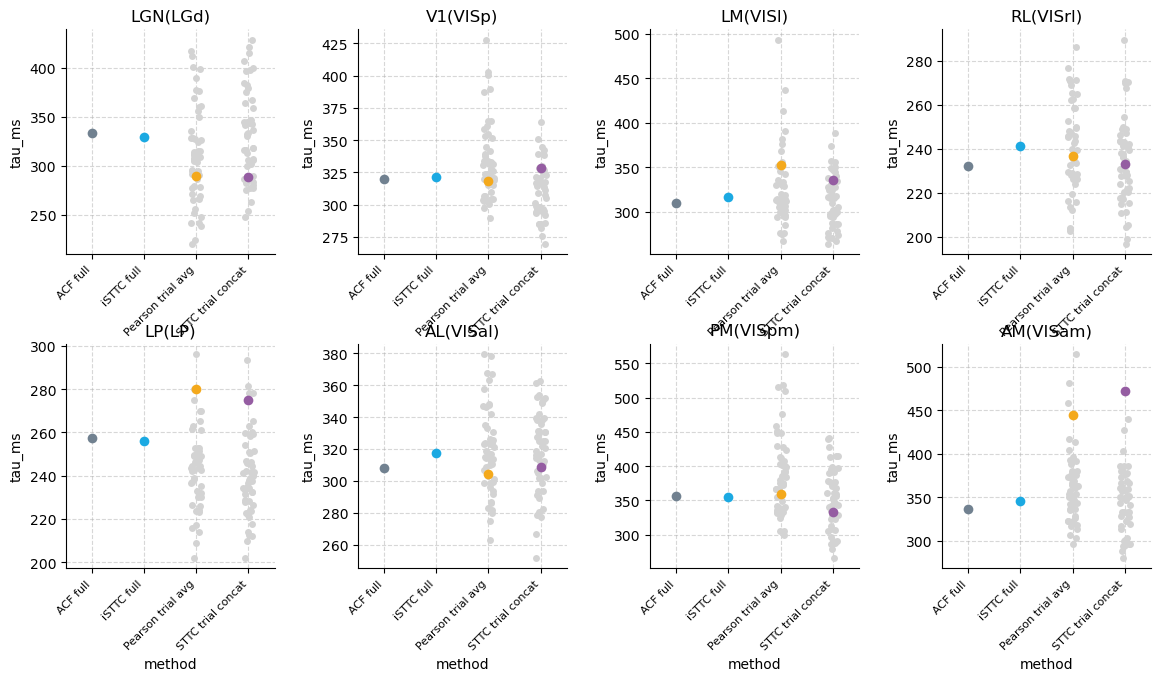

In [39]:
categories = ['acf_full', 'isttc_full', 'pearsonr_trial_avg_random', 'sttc_trial_concat_random']
custom_labels = ['ACF full', 'iSTTC full', 'Pearson trial avg', 'STTC trial concat']

fig, axes = plt.subplots(2, 4, figsize=(14, 7), sharey=False)
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for area_idx, area in enumerate(brain_areas_axes_ticks):
    y_idx = area_idx % 4 
    x_idx = area_idx // 4
    sns.stripplot(data=df_all.query('area == @area'), x='method', y='tau_ms', color='lightgray', order=categories, 
                  ax=axes[x_idx, y_idx])
    sns.stripplot(data=df_all_full_subset.query('area == @area'), x='method', y='tau_ms', palette=colors, s=7, order=categories, 
                  ax=axes[x_idx, y_idx])
    axes[x_idx, y_idx].set_title(f'{brain_areas_names[area_idx]}({brain_areas_axes_ticks[area_idx]})')
    
for ax in axes.flat:
    ax.grid(True, linestyle='--', alpha=0.5)
    sns.despine(ax=ax)
    ax.xaxis.set_major_locator(FixedLocator(range(len(categories))))
    ax.set_xticklabels(custom_labels, rotation=45, ha='right', fontsize=8)

if save_fig:
    fig.savefig(fig_folder + 'tau_per_area_4methods_50_trial_iterations.png', bbox_inches='tight', dpi=300)
    fig.savefig(fig_folder + 'tau_per_area_4methods_50_trial_iterations.svg', bbox_inches='tight')